# Expectation Value Experiment Examples

In [1]:
import numpy as np
import qiskit
from qiskit.experiment import ExpectationValue, ExpectationValueAnalysis
from qiskit.quantum_info import (
    Clifford,
    SparsePauliOp,
    random_hermitian,
    random_statevector,
)

# from qiskit.ignis.measurement import (MeasMitigation, MeasMitigationAnalysis)

## Backends

In [2]:
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.test.mock import FakeBoeblingen

backend = FakeBoeblingen()
noise_model = NoiseModel.from_backend(backend, warnings=False)
sim = AerSimulator(basis_gates=noise_model.basis_gates)

# Basic Example

Compute the exectation value of a random operator on a random state

In [3]:
seed = 15
num_qubits = 1

op = random_hermitian(2 ** num_qubits, seed=seed)
print(op)


state = random_statevector(2 ** num_qubits, seed=seed)
print(state)

Operator([[-1.43087302+0.j        ,  0.19696918+0.26204331j],
          [ 0.19696918-0.26204331j, -0.93654772+0.j        ]],
         input_dims=(2,), output_dims=(2,))
Statevector([-0.44834237+0.66503452j,  0.57371309+0.16604667j],
            dims=(2,))


First we can compute the exact expval and standard error using the operator classes

In [4]:
shots = 1000
expval = state.expectation_value(op).real
variance = state.expectation_value(op.dot(op)).real - expval ** 2

error = np.sqrt(variance / shots)
print("Exact value: {:.3f} \u00B1 {:.3f}".format(expval, error))

Exact value: -1.073 ± 0.013


### Running the experiment

Computing this expectation value experimentally on a backend can be done in two-lines using the ExpectationValue experiment classes.

The default method is to decompose the operator into Pauli measurement circuits

In [7]:
job = ExpectationValue(op, initial_state=state).execute(sim, shots=1000)
expval, error = ExpectationValueAnalysis(job).analyze()
print("Pauli method value: {:.3f} \u00B1 {:.3f}".format(expval, error))

Pauli method value: -1.076 ± 0.010


There is also a snapshot method for computing the exact expectation value and std error using the Aer simulator. We can see this agrees with the above exact computation

In [8]:
job = ExpectationValue(op, initial_state=state, method="snapshot").execute(sim)
expval, error = ExpectationValueAnalysis(job, method="snapshot").analyze()
print("Aer snapshot method value: {:.3f} \u00B1 {:.3f}".format(expval, error))

Aer snapshot method value: -1.073 ± 0.012


### ExpectationValue experiment class

Now we describe some basic properties of these classes. The first `ExpectationValue` class handles composing the input state and observable into measurement circuits for execution

In [9]:
experiment = ExpectationValue(op, initial_state=state)

We can see the measurement circuits and metadata for the experiment to be executed:

In [10]:
for circ in experiment.circuits():
    print(circ.draw())

     ┌────────────────────────────────────────────────┐ ░ ┌─┐
q_0: ┤ Initialize(-0.44834+0.66503j,0.57371+0.16605j) ├─░─┤M├
     └────────────────────────────────────────────────┘ ░ └╥┘
c: 1/══════════════════════════════════════════════════════╩═
                                                           0 
     ┌────────────────────────────────────────────────┐┌───┐ ░ ┌─┐
q_0: ┤ Initialize(-0.44834+0.66503j,0.57371+0.16605j) ├┤ H ├─░─┤M├
     └────────────────────────────────────────────────┘└───┘ ░ └╥┘
c: 1/═══════════════════════════════════════════════════════════╩═
                                                                0 
     ┌────────────────────────────────────────────────┐┌─────┐┌───┐ ░ ┌─┐
q_0: ┤ Initialize(-0.44834+0.66503j,0.57371+0.16605j) ├┤ Sdg ├┤ H ├─░─┤M├
     └────────────────────────────────────────────────┘└─────┘└───┘ ░ └╥┘
c: 1/══════════════════════════════════════════════════════════════════╩═
                                                           

In [11]:
for meta in experiment.metadata():
    print(meta)

{'experiment': 'expval', 'qubits': None, 'method': 'Pauli', 'basis': 'I', 'coeff': (-1.183710369589401+0j)}
{'experiment': 'expval', 'qubits': None, 'method': 'Pauli', 'basis': 'X', 'coeff': (0.19696917840019046+0j)}
{'experiment': 'expval', 'qubits': None, 'method': 'Pauli', 'basis': 'Y', 'coeff': (-0.26204331395099895+0j)}
{'experiment': 'expval', 'qubits': None, 'method': 'Pauli', 'basis': 'Z', 'coeff': (-0.24716265326968628+0j)}


### Running the experiment on a backend

The execution of the experiment can be done using the `execute` method. This automatically transpiles and assembles the circuits for the backend, and stores the metadata in the run qobj.

In [12]:
job = experiment.execute(sim)

This is equivalent to the following

In [13]:
circuits = qiskit.transpile(experiment.circuits(), sim)
metadata = experiment.metadata()
qobj = qiskit.assemble(circuits, sim, qobj_header={"metadata": metadata})
job = sim.run(qobj)

### Processing Results

Once the job has finished executing the results can be processed using the `ExpectationValueAnalysis` analysis class. The analysis is done by calling the `analyze` method

In [14]:
result = ExpectationValueAnalysis(job)
result.analyze()

(-1.080091397975608, 0.009834980332646343)

The analysis result and data are stored in the ExperimentResult object

In [15]:
result.last_result

(-1.080091397975608, 0.009834980332646343)

In [16]:
result.data

[{'1': 363, '0': 661},
 {'0': 340, '1': 684},
 {'0': 35, '1': 989},
 {'1': 358, '0': 666}]

In [17]:
result.metadata

[{'basis': 'I',
  'coeff': [-1.183710369589401, 0.0],
  'experiment': 'expval',
  'method': 'Pauli',
  'qubits': None},
 {'basis': 'X',
  'coeff': [0.19696917840019046, 0.0],
  'experiment': 'expval',
  'method': 'Pauli',
  'qubits': None},
 {'basis': 'Y',
  'coeff': [-0.26204331395099895, 0.0],
  'experiment': 'expval',
  'method': 'Pauli',
  'qubits': None},
 {'basis': 'Z',
  'coeff': [-0.24716265326968628, 0.0],
  'experiment': 'expval',
  'method': 'Pauli',
  'qubits': None}]

# Graph State Fidelity Example

Now lets consider a more complicated example of estimating the fidelity of a graph state. We can do this by computing the stabilizers of a graph state, and defining our observable to be $\sum_{i=1}^N S_i / N$ for $N=2^n$

In [18]:
def coupling_graph(backend, max_qubits):
    """Get coupling graph for a backend."""
    return np.unique(
        [
            sorted(i)
            for i in backend.configuration().coupling_map
            if max(i) < max_qubits
        ],
        axis=0,
    ).tolist()

First we generate a graph state circuit for the native coupling map of a backend

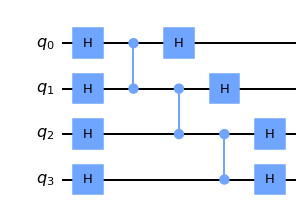

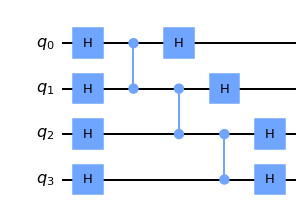

In [19]:
num_qubits = 4
graph = coupling_graph(backend, num_qubits)

circ = qiskit.QuantumCircuit(num_qubits)
circ.h(range(num_qubits))
for i, j in graph:
    circ.cz(i, j)
circ.h(range(num_qubits))
circ.draw("mpl")

Next we use the Clifford class to find the stabilizers for this state

In [20]:
clifford = Clifford(circ)
stabilizers = clifford.stabilizer.pauli
print(stabilizers.to_labels())

['IIXZ', 'IXZX', 'XZXI', 'ZXII']


Next we convert the stabilizers to a SparsePauliOp observable

In [21]:
N = len(stabilizers)
op = SparsePauliOp(stabilizers, N * [1 / N])

## Including measurement error mitigator
Related to: https://github.com/Qiskit/qiskit-terra/pull/6485

We now will include measurement error mitigation. This requires first running a mitigator calibration experiment, which can be used in the expectation value analysis to apply mitigation.

Since we are using a noise model with single-qubit readout error we will use the tensored mitigation method

In [22]:
# mit_job = MeasMitigation(circ.num_qubits, method='tensored').execute(sim, shots=8192, noise_model=noise_model)
# mitigator = MeasMitigationAnalysis(mit_job, method='tensored').analyze()
# mitigator.plot_assignment_matrix()

### Pauli method experiment
Finally we can run the expectation value experiment, the result of which is the state fideilty of our prepared input graph state

In [23]:
# Run without noise
job = ExpectationValue(op, initial_state=circ).execute(sim)
expval, error = ExpectationValueAnalysis(job).analyze()
print("F(ideal) = {:.1f} \u00B1 {:.1f}".format(expval, error))

F(ideal) = 1.0 ± 0.0


In [24]:
# Run with noise
job = ExpectationValue(op, initial_state=circ).execute(
    sim, shots=8192, noise_model=noise_model
)
expval, error = ExpectationValueAnalysis(job).analyze()
print("F(noise) = {:.3f} \u00B1 {:.3f}".format(expval, error))

F(noise) = 0.786 ± 0.003


In [25]:
# Run with noise and mitigation
# expval, error = ExpectationValueAnalysis(job, mitigator=mitigator).analyze()
# print('F(noise + mitigation) = {:.3f} \u00B1 {:.3f}'.format(expval, error))

### Snapshot method experiment

We can also use the snapshot method to compute this.

In [26]:
# Run without noise
job = ExpectationValue(op, initial_state=circ, method="snapshot").execute(sim)
expval, error = ExpectationValueAnalysis(job, method="snapshot").analyze()
print("F(ideal) = {:.1f} \u00B1 {:.1f}".format(expval, error))

F(ideal) = 1.0 ± 0.0


Running with noise using the snapshot method will only include the effect of gate error, not readout error. This is because expectation values are computed exactly from the noisy state

In [27]:
# Run with noise
job = ExpectationValue(op, initial_state=circ, method="snapshot").execute(
    sim, shots=1024, noise_model=noise_model
)
expval, error = ExpectationValueAnalysis(job, method="snapshot").analyze()
print("F(noise) = {:.3f} \u00B1 {:.3f}".format(expval, error))

F(noise) = 0.970 ± 0.005
